In [1]:
%run ../aux_funcs.py
%run ../RSRG.py

def linear_fit(x, m, b):
    return m*x+b

In [2]:
L = 40
steps = 1400
measure_step = 10

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

J_ij_vals, h_vals, R0_array, mu_array = run_decimation(L, steps, measure_step, a_vals, b_vals, track_moments=True)

/home/jebediah/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


[0.07293883 1.69131471]
0.14587765065835256


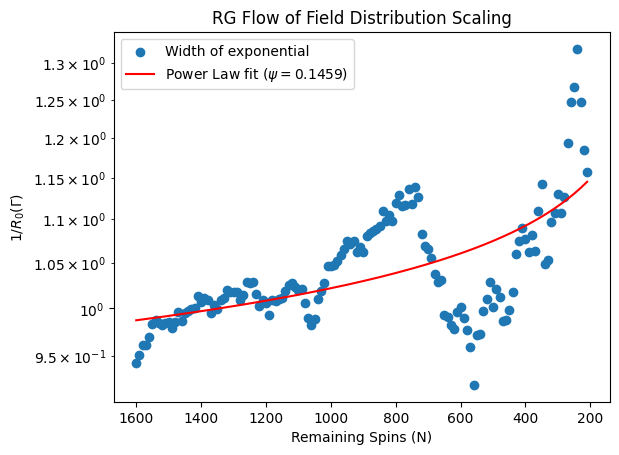

In [3]:
x = L*L - np.arange(len(R0_array))*measure_step
y = 1/np.array(R0_array)
R_length = len(y)

plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[int(R_length/2):], y[int(R_length/2):])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
#plt.ylim(0, 1.5)

[-0.04419099  0.33309617]


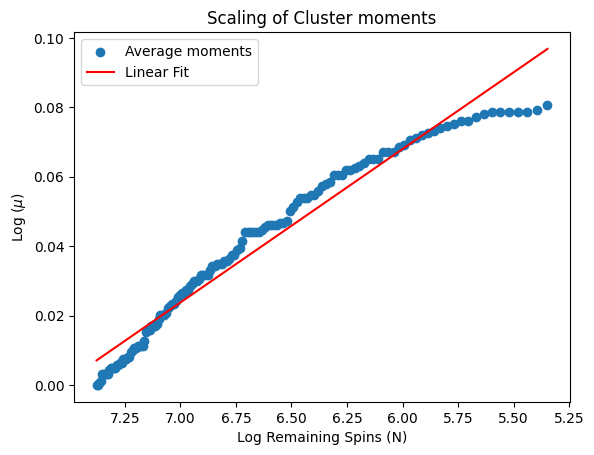

In [4]:
x = np.log(L*L - np.arange(len(R0_array))*measure_step)
y = np.log(mu_array)
R_length = len(y)

plt.scatter(x, y, label='Average moments')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(linear_fit, x[int(R_length/100):], y[int(R_length/100):])
print(popt)

plt.title("Scaling of Cluster moments")
plt.xlabel("Log Remaining Spins (N)")
plt.ylabel(r"Log $(\mu)$")
plt.plot(x, linear_fit(x, *popt), color='red', label=r'Linear Fit')

plt.gca().invert_xaxis()
plt.legend()

#plt.ylim(0, 1.5)